In [37]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import glob
import shapely
from shapely import wkt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from shapely.affinity import affine_transform


## Processing RADAR ##

In [38]:
import xesmf
import pickle
import xarray as xr

def read_radar(path):
    data= np.fromfile(path, dtype='float16')
    indexes_x=data[data.size//3:][0::2].astype(int)
    indexes_y=data[data.size//3:][1::2].astype(int)
    rain_all=np.zeros((500,500))
    rain_all[indexes_x,indexes_y]=data[:data.size//3]
    return rain_all*0.1

def regrid_radar(radar_data, sum_x,sum_y,x_dim,y_dim):
    global nested_grid_with_bounds, regridder_conserve, original_grid_with_bounds
    ds_src=xr.Dataset(original_grid_with_bounds)
    ds_src['rain'] = xr.DataArray(radar_data, dims=['lat', 'lon'])
    rn = regridder_conserve(ds_src['rain']).data
    rn_all=np.zeros((y_dim,x_dim))
    rn_all[sum_y:sum_y+rn.shape[0],sum_x:sum_x+rn.shape[1]]=rn
    return rn_all


def process_radar(radar_files, indexes,sum_x,sum_y,x_dim,y_dim):
    radar_data = np.zeros((500,500))
    for radar_file in radar_files:
        radar_data += read_radar(radar_file)
    radar_subsampled = regrid_radar(radar_data,sum_x,sum_y,x_dim,y_dim)
    radar_subsampled[indexes==0]=np.nan
    radar_data[radar_data<.1]=0
    return radar_subsampled

nested_grid_with_bounds = {
    'lon': np.round(np.arange(-56.7,-52.2,.1),2),
    'lat': np.round(np.arange(-18.2,-22.4,-.1),2),
    'lon_b': np.round(np.arange(-56.75,-52.2,.1),2),
    'lat_b': np.round(np.arange(-18.15,-22.4,-.1),2)}

with open('auxiliary_data/radar_grid_with_bounds.pkl', 'rb') as f:
    original_grid_with_bounds = pickle.load(f)

ds_src = xr.Dataset(original_grid_with_bounds)
regridder_conserve = xesmf.Regridder(
    ds_src, 
    nested_grid_with_bounds, 
    method='conservative', 
    filename=f'auxiliary_data/regrid_conservative_gsmap.nc', 
    reuse_weights=True)


#integrating radar
radar_files=sorted(glob.glob('radar/*.dat'))
radar_data = np.zeros((500,500))
for radar_file in radar_files:
    radar_data += read_radar(radar_file)

sum_x = 97;sum_y = 96
radar_subsampled = regrid_radar(radar_data,sum_x,sum_y,291,232) #shape (232,291)

#grid radar
ds=xr.open_dataset('/home/milton/Downloads/jaraguari_201801010005.nc')
xx,yy=np.meshgrid(ds['x'].data,ds['y'].data)

#grid PPS
Lon=np.round(np.append(np.arange(0,180,.1),np.arange(-180,0,0.1)),2)
Lat=np.round(np.arange(60,-60,-.1),2)
X_grid,Y_grid=np.meshgrid(Lon[2936:3227],Lat[686:918])    

#adjusting
radar_data[radar_data<.1]=np.nan
radar_subsampled_plot=radar_subsampled.copy()
radar_subsampled_plot[radar_subsampled_plot<.1]=np.nan

#masking area out of scan area
mask_radar=np.load('auxiliary_data/indices_radar_mask.npy')
mask_pps = np.load('auxiliary_data/indices_gsmap_mask.npy')

radar_data[mask_radar==0]=np.nan
radar_subsampled_plot[mask_pps==0]=np.nan

## Satelite precipitation products ##

In [39]:
def read_pps(path):
    data= np.fromfile(path, dtype='float16').reshape(232,291)
    data=data.astype('float32')
    data[(data<.1)|(mask_pps==0)]=np.nan
    return data


data_mvk=read_pps('/home/milton/Documentos/GSMaP-Avaliation-Brazil/versions/mvk.20211015.2000.dat')
data_mvk_gauge=read_pps('/home/milton/Documentos/GSMaP-Avaliation-Brazil/versions/mvk.20211015.2000.dat')

data_nrt=read_pps('/home/milton/Documentos/GSMaP-Avaliation-Brazil/versions/nrt.20211015.2000.dat')
data_nrt_gauge=read_pps('/home/milton/Documentos/GSMaP-Avaliation-Brazil/versions/nrt.20211015.2000.dat')

data_now=read_pps('/home/milton/Documentos/GSMaP-Avaliation-Brazil/versions/now.20211015.2000.dat')
data_now_gauge=read_pps('/home/milton/Documentos/GSMaP-Avaliation-Brazil/versions/now.20211015.2000.dat')


## Clusters 

In [41]:
LON_MAX=X_grid.max(); LON_MIN=X_grid.min()
LAT_MAX=Y_grid.min(); LAT_MIN=Y_grid.max() #changed because of grid
X_DIM=291; Y_DIM=232
xres = (LON_MAX - LON_MIN) / X_DIM
yres = (LAT_MAX - LAT_MIN) / Y_DIM
geotransform = (xres, 0, 0, yres, LON_MIN, LAT_MIN)

def read_clusters(path):
    track=pd.read_parquet(path)
    track['geometry'] = track['geometry'].apply(wkt.loads)
    track['coords'] = track['geometry'].apply(lambda geom: affine_transform(geom, geotransform))
    track = gpd.GeoDataFrame(track, geometry='coords')
    return track

track_mvk=read_clusters('/home/milton/Documentos/GSMaP-Avaliation-Brazil/clusters/mvk_20211015_2000.parquet')
track_mvk_gauge=read_clusters('/home/milton/Documentos/GSMaP-Avaliation-Brazil/clusters/mvk_gauge_20211015_2000.parquet')

track_nrt=read_clusters('/home/milton/Documentos/GSMaP-Avaliation-Brazil/clusters/nrt_20211015_2000.parquet')
track_nrt_gauge=read_clusters('/home/milton/Documentos/GSMaP-Avaliation-Brazil/clusters/nrt_gauge_20211015_2000.parquet')

track_now=read_clusters('/home/milton/Documentos/GSMaP-Avaliation-Brazil/clusters/now_20211015_2000.parquet')
track_now_gauge=read_clusters('/home/milton/Documentos/GSMaP-Avaliation-Brazil/clusters/now_gauge_20211015_2000.parquet')

## Metrics function

In [42]:
def calculate_RMSE(pps, radar):
    return np.sqrt(np.mean((pps - radar) ** 2))

def calculate_MAE(pps, radar): #1
    return np.mean(np.abs(pps - radar))

def calculate_bias(pps, radar): #4
    bias = np.sum(pps - radar) / len(radar)
    return bias

## plot functions

In [43]:
radar_radii=np.loadtxt('auxiliary_data/radar_radii.txt') #index 0 and 1 inner circle | 2 and 3 exterior circle


def set_cartopy_cluster(ax):
    ax.set_extent([-67, -42, -31.7, -12], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS,linewidth=.6)
    ax.add_feature(cfeature.STATES,linewidth=.3)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=.2, color='gray', alpha=0.5, linestyle='--')
    gl.left_labels = True
    gl.bottom_labels = True
    gl.right_labels = False
    gl.top_labels = False


def set_cartopy_comparison(ax):
    ax.set_extent([-56.25, -52.5, -22, -18.5], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS,linewidth=.6)
    ax.add_feature(cfeature.STATES,linewidth=.3)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=.2, color='gray', alpha=0.5, linestyle='--')
    gl.left_labels = True
    gl.bottom_labels = True
    gl.right_labels = False
    gl.top_labels = False
    gl.xlocator = mticker.FixedLocator([-56,-55, -54, -53, ])
    gl.ylocator = mticker.FixedLocator([-22, -21,-20, -19])


def plot_cluster(ax,track,product):
    set_cartopy_cluster(ax)
    c=ax.pcolormesh(X_grid,Y_grid,radar_subsampled_plot,cmap='jet',transform=ccrs.PlateCarree(),vmin=.1,vmax=20)
    cbar=plt.colorbar(c,ax=ax,orientation='vertical',pad=.01,shrink=.4)
    cbar.set_label(r'mm h$^{-1}$')
    ax.set_title(product)
    ax.plot(radar_radii[2],radar_radii[3],'--',color='r')
    ax.plot(radar_radii[0],radar_radii[1],'--',color='r')
    #plot boundaries
    track.plot(ax=ax,color='.5',linewidth=3,alpha=.3)
    track.boundary.plot(ax=ax,color='.3',linewidth=3)

def plot_comparison(ax,track,data,product):
    for i in range(3):
        ax[i].axis('off')
        ax[i] = plt.subplot(2,2,i+1, projection=ccrs.PlateCarree())
        set_cartopy_comparison(ax[i])
        ax[i].plot(radar_radii[2],radar_radii[3],'--',color='r')
        ax[i].plot(radar_radii[2],radar_radii[3],'--',color='r')
        track.plot(ax=ax[i],color='.5',linewidth=3,alpha=.2)
        track.boundary.plot(ax=ax[i],color='.3',linewidth=3)

    ax[0].pcolormesh(X_grid,Y_grid,data,cmap='jet',transform=ccrs.PlateCarree(),vmin=0.1,vmax=20)
    ax[1].pcolormesh(xx,yy,radar_data,cmap='jet',transform=ccrs.PlateCarree(),vmin=0.1,vmax=20)
    c=ax[2].pcolormesh(X_grid,Y_grid,radar_subsampled_plot,cmap='jet',transform=ccrs.PlateCarree(),vmin=0.1,vmax=20)
    cbar=plt.colorbar(c,ax=ax,orientation='vertical',pad=.01,shrink=.4)
    cbar.set_label(r'mm h$^{-1}$')
    ax[0].set_title(product)
    ax[1].set_title('Original RADAR data')
    ax[2].set_title(r'1$^{st}$ order conservative')
    sns.kdeplot(data[~np.isnan(data)], fill=True, ax=ax[3],color='b',linewidth=1.5,label='GSMaP-Now')
    sns.kdeplot(radar_data[~np.isnan(radar_data)], fill=True, ax=ax[3],color='orange',linewidth=1.5,label='Original RADAR data')
    sns.kdeplot(radar_subsampled[~np.isnan(data)], fill=True, ax=ax[3],color='green',linewidth=1.5,label=r'1$^{st}$ order conservative')
    ax[3].legend()
    ax[3].set_xlabel(r'mm h$^{-1}$')
    ax[3].set_xlim(-.5,20)



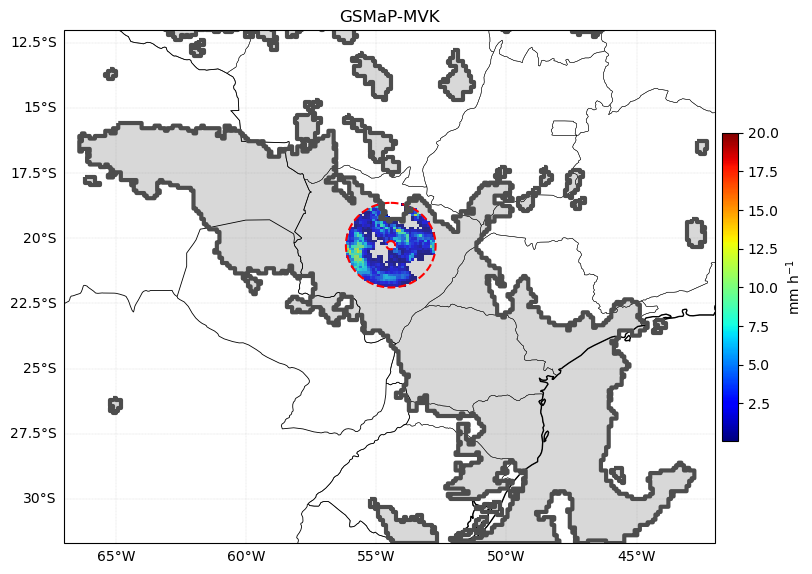

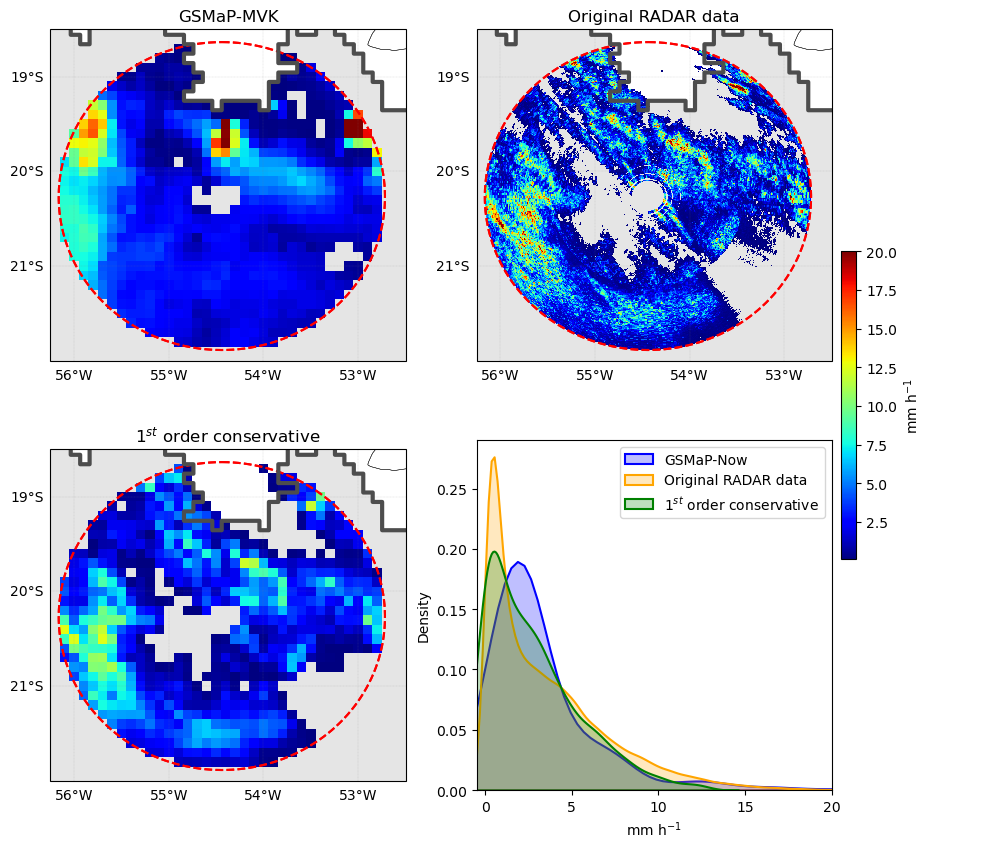

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
plot_cluster(ax,track_mvk,'GSMaP-MVK')
plt.savefig('Cluster_figures/mvk.png',dpi=300,bbox_inches='tight')

fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax=ax.ravel()
plot_comparison(ax,track_mvk,data_mvk,'GSMaP-MVK')
plt.savefig('Comparison_figures/mvk.png',dpi=300,bbox_inches='tight')


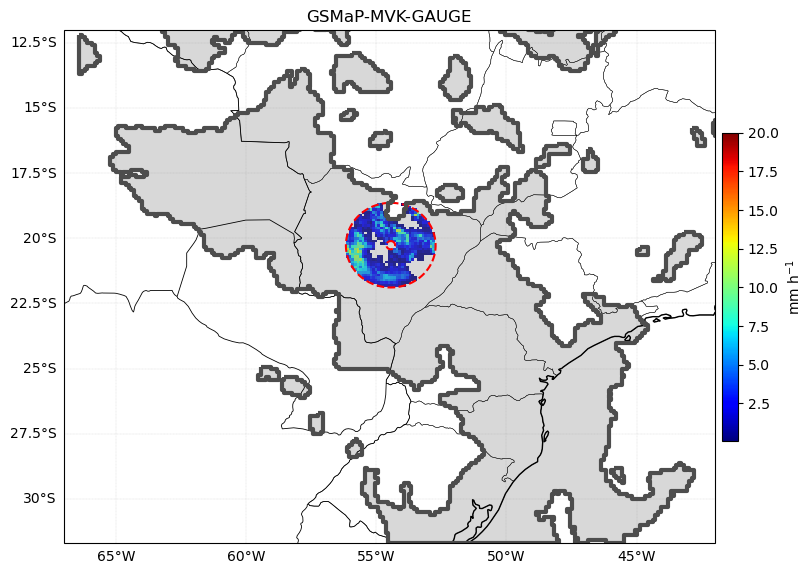

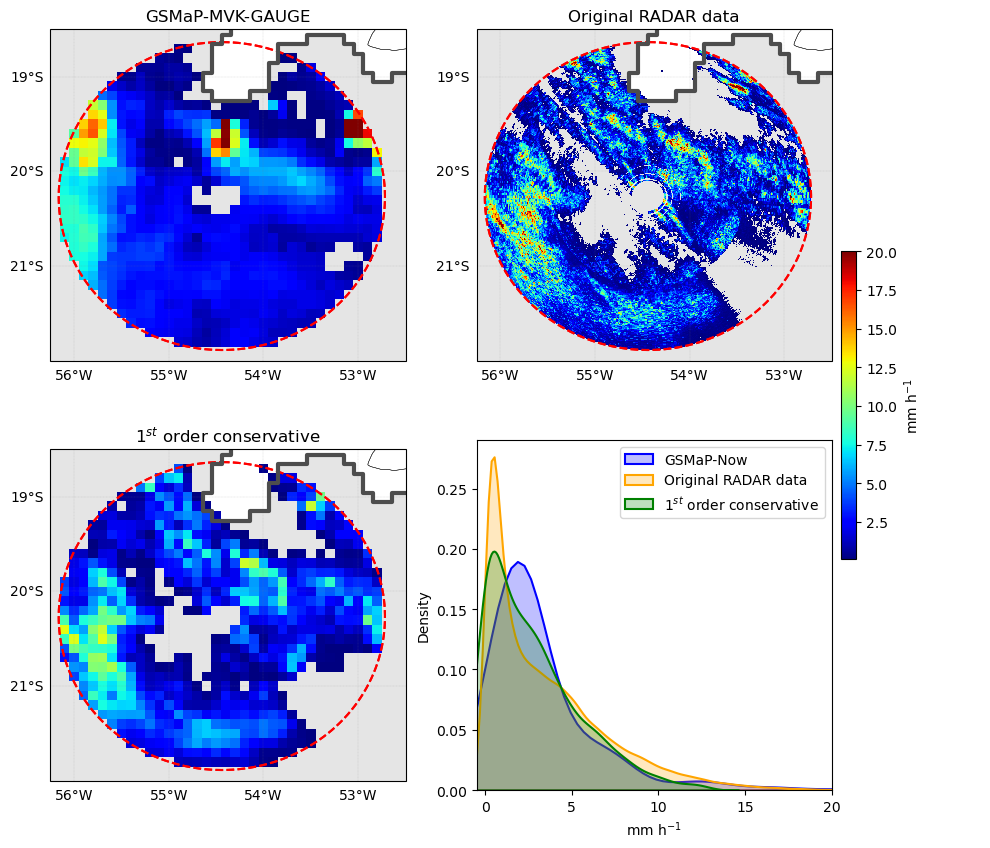

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
plot_cluster(ax,track_mvk_gauge,'GSMaP-MVK-GAUGE')
plt.savefig('Cluster_figures/mvk-gauge.png',dpi=300,bbox_inches='tight')

fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax=ax.ravel()
plot_comparison(ax,track_mvk_gauge,data_mvk_gauge,'GSMaP-MVK-GAUGE')
plt.savefig('Comparison_figures/mvk-gauge.png',dpi=300,bbox_inches='tight')


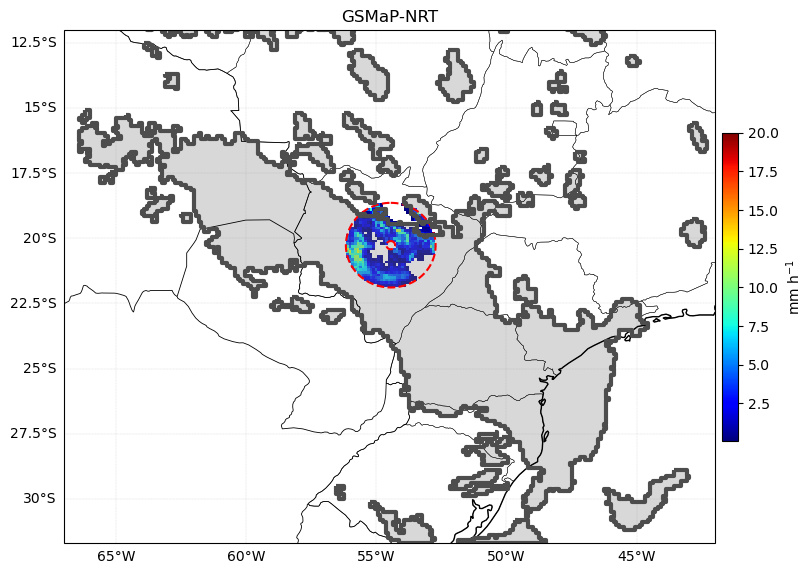

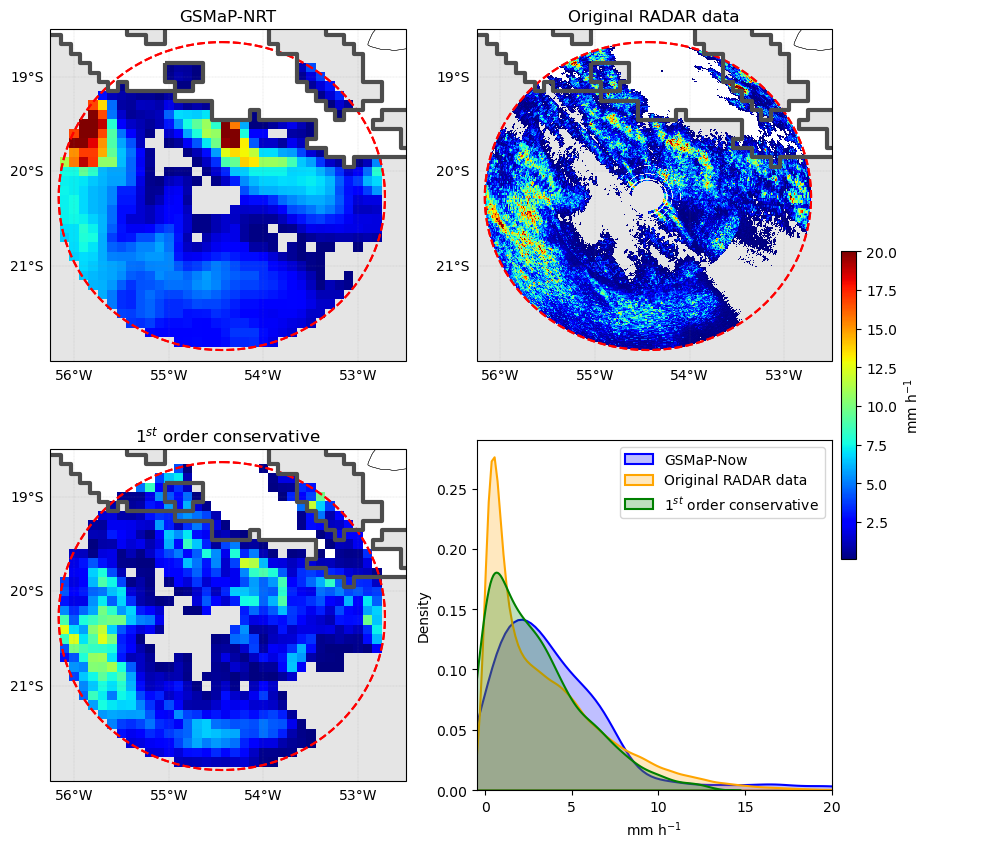

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
plot_cluster(ax,track_nrt,'GSMaP-NRT')
plt.savefig('Cluster_figures/nrt.png',dpi=300,bbox_inches='tight')

fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax=ax.ravel()
plot_comparison(ax,track_nrt,data_nrt,'GSMaP-NRT')
plt.savefig('Comparison_figures/nrt.png',dpi=300,bbox_inches='tight')


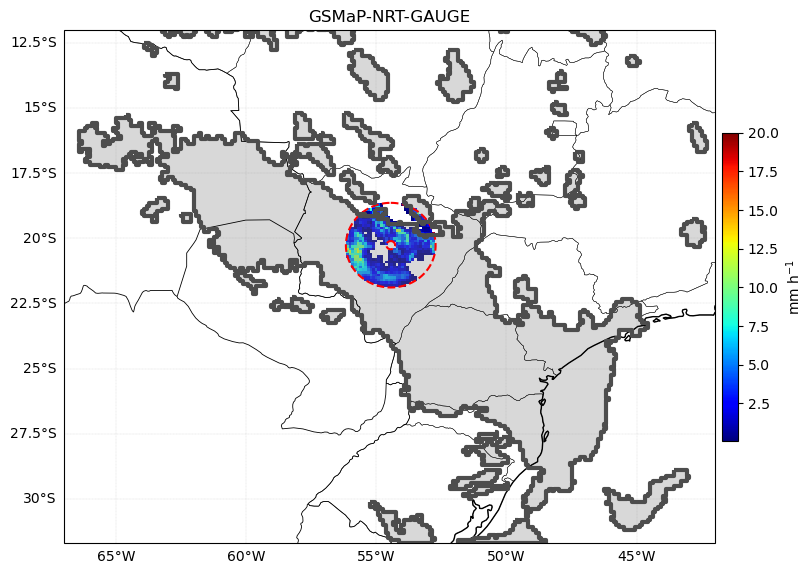

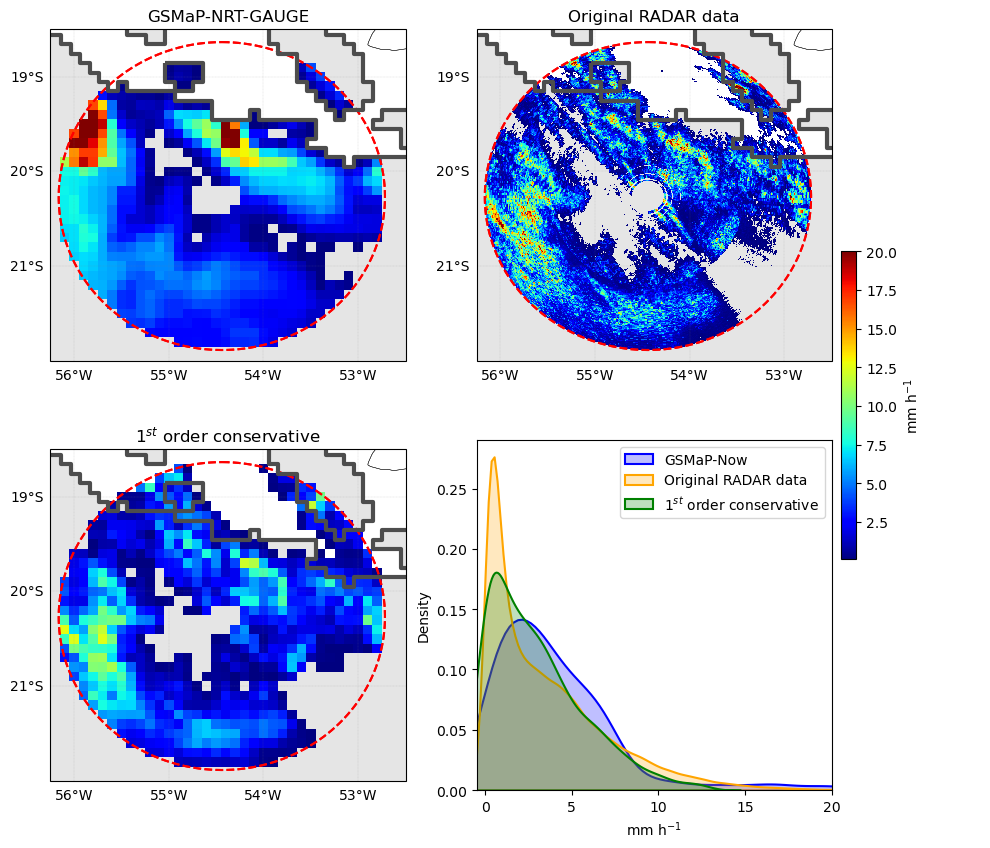

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
plot_cluster(ax,track_nrt_gauge,'GSMaP-NRT-GAUGE')
plt.savefig('Cluster_figures/nrt-gauge.png',dpi=300,bbox_inches='tight')

fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax=ax.ravel()
plot_comparison(ax,track_nrt_gauge,data_nrt_gauge,'GSMaP-NRT-GAUGE')
plt.savefig('Comparison_figures/nrt-gauge.png',dpi=300,bbox_inches='tight')


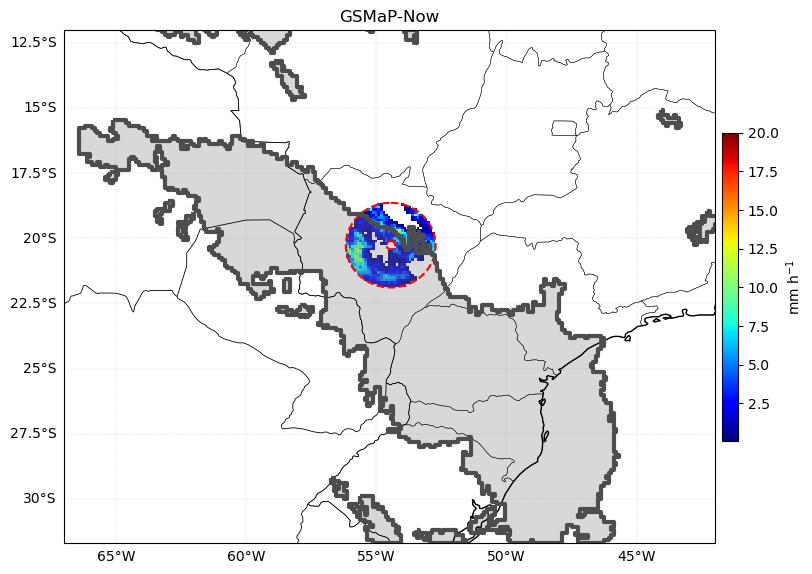

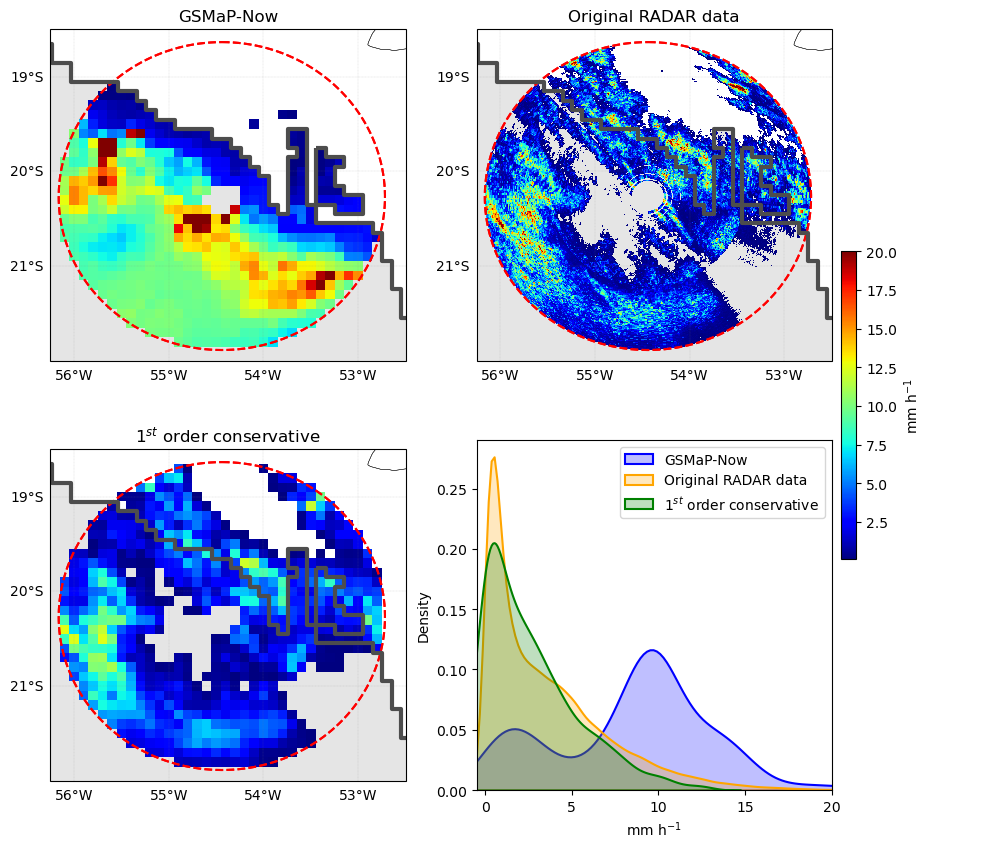

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
plot_cluster(ax,track_now,'GSMaP-Now')
plt.savefig('Cluster_figures/now.png',dpi=300,bbox_inches='tight')

fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax=ax.ravel()
plot_comparison(ax,track_now,data_now,'GSMaP-Now')
plt.savefig('Comparison_figures/now.png',dpi=300,bbox_inches='tight')


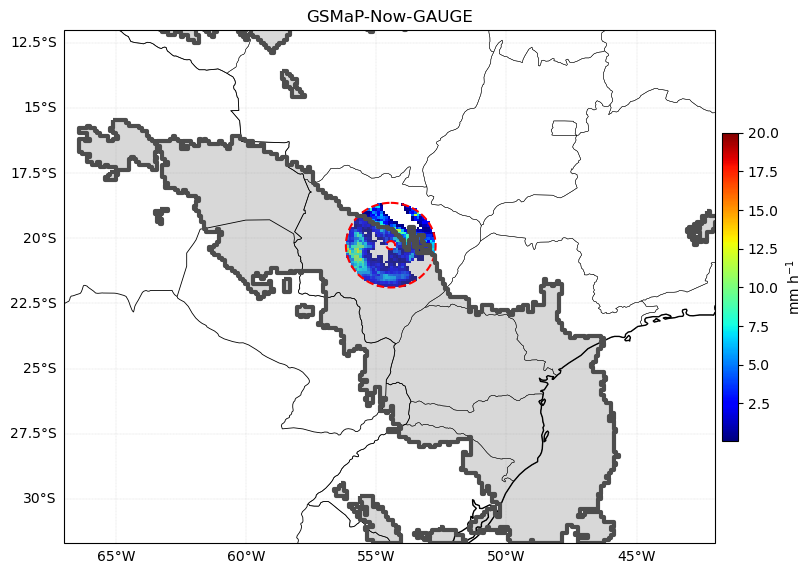

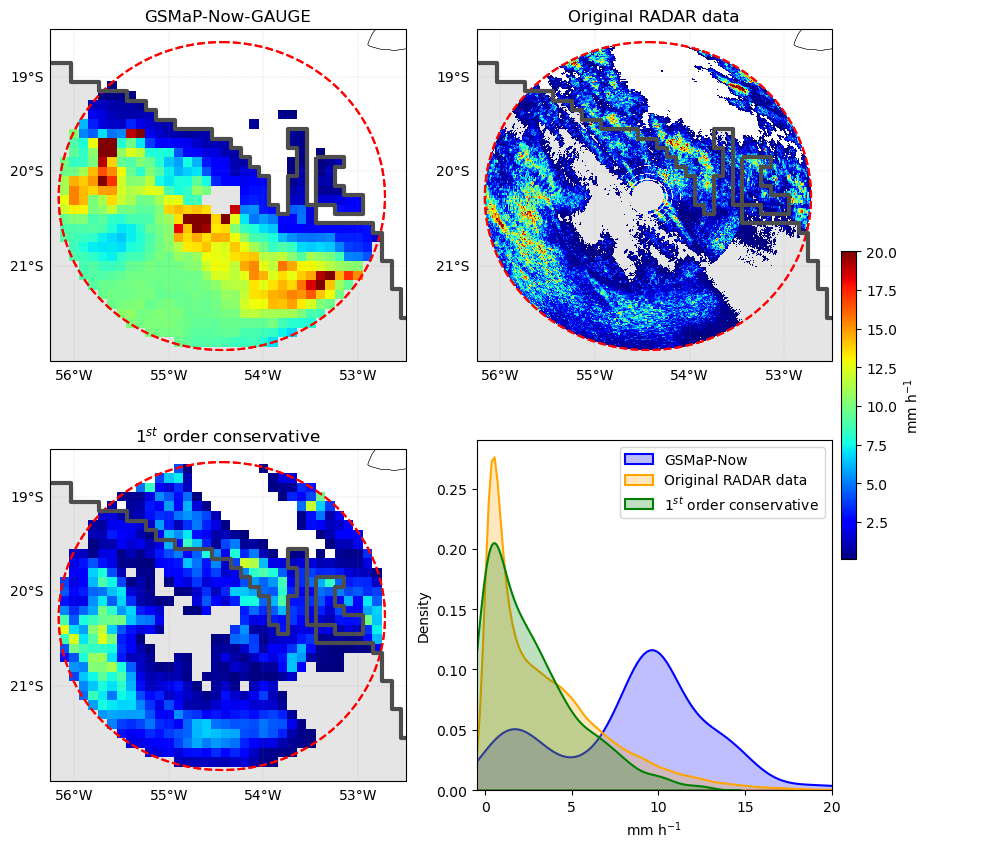

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
plot_cluster(ax,track_now_gauge,'GSMaP-Now-GAUGE')
plt.savefig('Cluster_figures/now-gauge.png',dpi=300,bbox_inches='tight')

fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax=ax.ravel()
plot_comparison(ax,track_now_gauge,data_now,'GSMaP-Now-GAUGE')
plt.savefig('Comparison_figures/now-gauge.png',dpi=300,bbox_inches='tight')


In [51]:
#print RMSE, MAE and Bias
print('MVK')
print('RMSE:',calculate_RMSE(data_mvk[~np.isnan(data_mvk)],radar_subsampled[~np.isnan(data_mvk)]))
print('MAE:',calculate_MAE(data_mvk[~np.isnan(data_mvk)],radar_subsampled[~np.isnan(data_mvk)]))
print('Bias:',calculate_bias(data_mvk[~np.isnan(data_mvk)],radar_subsampled[~np.isnan(data_mvk)]))

print('MVK-GAUGE')
print('RMSE:',calculate_RMSE(data_mvk_gauge[~np.isnan(data_mvk_gauge)],radar_subsampled[~np.isnan(data_mvk_gauge)]))
print('MAE:',calculate_MAE(data_mvk_gauge[~np.isnan(data_mvk_gauge)],radar_subsampled[~np.isnan(data_mvk_gauge)]))
print('Bias:',calculate_bias(data_mvk_gauge[~np.isnan(data_mvk_gauge)],radar_subsampled[~np.isnan(data_mvk_gauge)]))

print('NRT')
print('RMSE:',calculate_RMSE(data_nrt[~np.isnan(data_nrt)],radar_subsampled[~np.isnan(data_nrt)]))
print('MAE:',calculate_MAE(data_nrt[~np.isnan(data_nrt)],radar_subsampled[~np.isnan(data_nrt)]))
print('Bias:',calculate_bias(data_nrt[~np.isnan(data_nrt)],radar_subsampled[~np.isnan(data_nrt)]))

print('NRT-GAUGE')
print('RMSE:',calculate_RMSE(data_nrt_gauge[~np.isnan(data_nrt_gauge)],radar_subsampled[~np.isnan(data_nrt_gauge)]))
print('MAE:',calculate_MAE(data_nrt_gauge[~np.isnan(data_nrt_gauge)],radar_subsampled[~np.isnan(data_nrt_gauge)]))
print('Bias:',calculate_bias(data_nrt_gauge[~np.isnan(data_nrt_gauge)],radar_subsampled[~np.isnan(data_nrt_gauge)]))

print('NOW')
print('RMSE:',calculate_RMSE(data_now[~np.isnan(data_now)],radar_subsampled[~np.isnan(data_now)]))
print('MAE:',calculate_MAE(data_now[~np.isnan(data_now)],radar_subsampled[~np.isnan(data_now)]))
print('Bias:',calculate_bias(data_now[~np.isnan(data_now)],radar_subsampled[~np.isnan(data_now)]))
      
print('NOW-GAUGE')
print('RMSE:',calculate_RMSE(data_now_gauge[~np.isnan(data_now_gauge)],radar_subsampled[~np.isnan(data_now_gauge)]))
print('MAE:',calculate_MAE(data_now_gauge[~np.isnan(data_now_gauge)],radar_subsampled[~np.isnan(data_now_gauge)]))
print('Bias:',calculate_bias(data_now_gauge[~np.isnan(data_now_gauge)],radar_subsampled[~np.isnan(data_now_gauge)]))

MVK
RMSE: 4.8402498699696475
MAE: 2.528133644316329
Bias: 0.6160267274458874
MVK-GAUGE
RMSE: 4.8402498699696475
MAE: 2.528133644316329
Bias: 0.6160267274458874
NRT
RMSE: 4.541352401685745
MAE: 2.722425406705762
Bias: 1.1976044158346337
NRT-GAUGE
RMSE: 4.541352401685745
MAE: 2.722425406705762
Bias: 1.1976044158346337
NOW
RMSE: 8.270124365538566
MAE: 6.7263328345275415
Bias: 6.021739439613521
NOW-GAUGE
RMSE: 8.270124365538566
MAE: 6.7263328345275415
Bias: 6.021739439613521
